# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...
  No Changes to `C:\Users\simon\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\simon\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\simon\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\simon\.julia\environments\v1.9\Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function  testSondability_LP(capacity,Ub,BestUb,listobjs,listvals,Bestsol,n)

    TA, TO, TR = false, false, false
    
    if (capacity < 0) #test de faisabilité
        TA = true
        println("TA levé :capacité négative")
    elseif (Ub <= BestUb) #test d'optimalité
        TO = true
        println("TO levé : test d'optimalité")
    elseif n==length(listobjs) #test de résolution
        TR = true
        println("TR levé : test de résolution")
        if (Ub > BestUb)
            BestUb = Ub
            for i in 1:length(listobjs)
                obj = listobjs[i]
                Bestsol[obj]= listvals[i]          
            end                  
        end        
    end
    return TA, TO, TR, Bestsol, BestUb
end
    



testSondability_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:
function Borne1(weight_courant, price_courant, capacity_courant,listvals,listobjs,price)
    somme=0
    for i in 1:length(listobjs)
        obj = listobjs[i]
        if listvals[i] == 1
            somme+=price[obj]
        end
    end
    if !isempty(weight_courant)
        indices = sortperm(price_courant./weight_courant, rev=true)
        return ((capacity_courant/weight_courant[indices[1]])*price_courant[indices[1]]+somme)
    else
        return somme
    end
end

function Borne2(weight_courant, price_courant, capacity_courant, listvals, listobjs, price,weight)
    
    # Initialiser la nouvelle liste des objets et des valeurs
    new_listobjs = deepcopy(listobjs)
    new_listvals = deepcopy(listvals)
    new_capacity_courant = capacity_courant
    new_weight_courant = deepcopy(weight_courant)
    new_price_courant = deepcopy(price_courant)
    
    # Calculer les ratios et les trier par ordre décroissant
    ratios = [(i, new_price_courant[i] / new_weight_courant[i]) for i in 1:length(weight_courant)]
    ratios = sort(ratios, by=x->x[2], rev=true)
    
    # Remplir le sac avec les objets selon le ratio décroissant        
    for (indice, _) in ratios
        i,obj=1,0
        while (i<=length(price) && (obj==0))
            if (price_courant[indice]==price[i] && weight_courant[indice]==weight[i])
                obj=i
            end
        i+=1
        end
        
        if weight_courant[indice] <= capacity_courant   
            push!(new_listobjs,obj)
            push!(new_listvals,1)
            new_capacity_courant -= weight_courant[indice]       
        elseif weight_courant[indice] > capacity_courant
            # L'objet ne peut pas rentrer entièrement
            fraction = new_capacity_courant /capacity_courant            
            push!(new_listobjs,obj)
            push!(new_listvals,fraction)
            new_capacity_courant = 0       
        end

        if new_capacity_courant == 0
            break  # Capacité du sac atteinte
        end
    end
    
    borne_sup=0
    # Calcule de la borne supérieure
    for i in 1:length(new_listobjs)
        obj = new_listobjs[i]
        if new_listvals[i] >0
            borne_sup+=price[obj]*new_listvals[i]
        end
    end
    return borne_sup
end

function Borne(weight_courant, price_courant, capacity_courant, listvals, listobjs, price,weight,option)
    if option==1
        return Borne1(weight_courant, price_courant, capacity_courant,listvals,listobjs,price)
    elseif option==2
        return Borne2(weight_courant, price_courant, capacity_courant, listvals, listobjs, price,weight)
    end
end

Borne (generic function with 1 method)

In [5]:
function separateNodeThenChooseNext(weight_courant, price_courant, capacity_courant,listvals,listobjs,price,weight,cas_non_traites)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node with bigger upperbound
    indices1 =sortperm(price_courant./weight_courant, rev=true)
    weight_courant1= deepcopy(weight_courant)
    price_courant1= deepcopy(price_courant)
    capacity_courant1=capacity_courant-weight_courant[indices1[1]]
    
    i,obj=1,0
    while (i<=length(price) && (obj==0))
        if (price_courant[indices1[1]]==price[i] && weight_courant[indices1[1]]==weight[i])
            obj=i
        end
        i+=1
    end

    listobjs1= deepcopy(listobjs)
    push!(listobjs1,obj)

    deleteat!(weight_courant1,indices1[1])
    deleteat!(price_courant1,indices1[1])

    println("\nbranch on object ", obj, "\n")
    
    listvals0= deepcopy(listvals)
    listvals1= deepcopy(listvals)

    listvals0=push!(listvals0,0.0)
    listvals1=push!(listvals1,1.0)

    #comparer les bornes sup des deux noeuds fils
    
    Ub0=Borne1(weight_courant1, price_courant1, capacity_courant, listvals0, listobjs1,price)
    Ub1=Borne1(weight_courant1, price_courant1, capacity_courant1, listvals1, listobjs1,price)

    push!(listobjs,obj)
    
    if (Ub0>Ub1)
        push!(cas_non_traites,(obj,1.0))
        push!(listvals,0.0)
    else
        push!(cas_non_traites,(obj,0.0))
        push!(listvals,1.0)
    end
    
end

function exploreNextNode(listobjs,listvals,listnodes,cas_non_traites)
    #this node is sondable, go back to parent node then right child if possible
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1 && (!isempty(cas_non_traites)))
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
        couple=pop!(cas_non_traites)
        (obj1,theval1)=couple
        #go to other child if possible, otherwise go back to parent
        while((obj1!=obj)  && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        elseif theval==0.0
            push!(listobjs,obj)
            push!(listvals,1.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop
end




exploreNextNode (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:
function supprimer_elements(matrice,indices)
    indices1=deepcopy(indices)
    sort!(indices1,rev=true)
    for i in 1:length(indices1)
        deleteat!(matrice,indices1[i])
    end
    return matrice
end

supprimer_elements (generic function with 1 method)

In [7]:
function solveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)
    n=length(price)
    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=Int64[]
    listvals=Float64[]
    listnodes=Int64[]

    BestUb::Float64=-1.0
    Bestsol=zeros(n)

    current_node_number::Int64=0
    stop = false
    
    cas_non_traites=[]

    while(!stop)
        println("\nNode number ", current_node_number)
        println("---------------")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        # Maj de price_courant, weight_courant, capacity_courant
        price_courant = deepcopy(price)
        weight_courant = deepcopy(weight)
        capacity_courant = capacity
        for i in 1:length(listobjs)
            obj = listobjs[i]
            if listvals[i] == 1
                capacity_courant = capacity_courant - weight[obj]
            end
        end
        supprimer_elements(price_courant, listobjs)
        supprimer_elements(weight_courant, listobjs)
        println("********")
        println("listobjs = ", listobjs)
        println("listvals = ", listvals)
        println("********")
        
        # Calcul de Ub(UpperBound)
        option=2
        Ub=Borne(weight_courant, price_courant, capacity_courant,listvals,listobjs,price,weight,option)
        println("Ub = ", Ub)

        TA, TO, TR, Bestsol, BestUb = testSondability_LP(capacity_courant,Ub,BestUb,listobjs,listvals,Bestsol,n)
        is_node_sondable = TA || TO || TR

        if (!is_node_sondable)
            println("Node number : ", current_node_number, " is not sondable")
            separateNodeThenChooseNext(weight_courant, price_courant, capacity_courant,listvals,listobjs,price,weight,cas_non_traites)
        else
            println("Node number : ", current_node_number, " is sondable")
            stop = exploreNextNode(listobjs,listvals,listnodes,cas_non_traites)
        end

        current_node_number = current_node_number + 1
    
    end

    println("\n******\n\nOptimal value = ", BestUb, "\n\nOptimal x=", Bestsol)

    return BestUb, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


solveKnapInstance (generic function with 1 method)

### Affichage du résultat final

In [8]:
function solveNdisplayKnap(filename)

    println("\n Branch-and-Bound for solving a knapsack problem. \n\n Solving instance '" * filename * "'\n")

    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(filename)


    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)


 Branch-and-Bound for solving a knapsack problem. 

 Solving instance 'InstancesKnapSack/test.opb.txt'


Node number 0
---------------
********
listobjs = Int64[]
listvals = Float64[]
********
Ub = 119.0
Node number : 0 is not sondable

branch on object 2


Node number 1
---------------
********
listobjs = [2]
listvals = [1.0]
********
Ub = 82.0
Node number : 1 is not sondable

branch on object 1


Node number 2
---------------
********
listobjs = [2, 1]
listvals = [1.0, 1.0]
********
Ub = 107.0
TA levé :capacité négative
Node number : 2 is sondable

Node number 3
---------------
********
listobjs = [2, 1]
listvals = [1.0, 0.0]
********
Ub = 77.0
Node number : 3 is not sondable

branch on object 4


Node number 4
---------------
********
listobjs = [2, 1, 4]
listvals = [1.0, 0.0, 1.0]
********
Ub = 77.0
Node number : 4 is not sondable

branch on object 3


Node number 5
---------------
********
listobjs = [2, 1, 4, 3]
listvals = [1.0, 0.0, 1.0, 1.0]
********
Ub = 77.0
TA levé :capacit

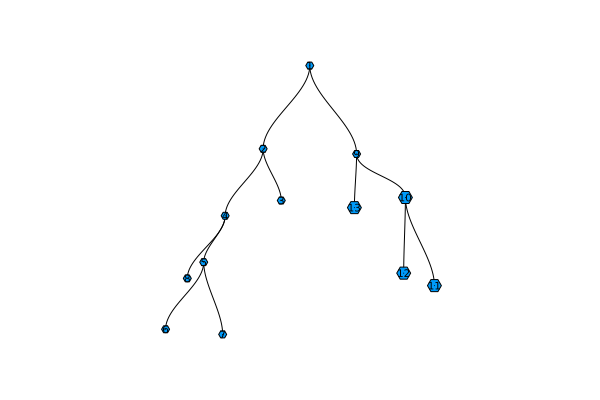

... end display. 


press enter to exit ! 


""

In [9]:
INSTANCE = "InstancesKnapSack/test.opb.txt"

solveNdisplayKnap(INSTANCE)
 
println("press enter to exit ! ")
readline()

### Affichage du résultat final

### Questions préliminaires: 
<span> 1-La règle de séparation est celle par ordre lexicographique. On choisit le premier objet dans la liste qui n'a pas été encore traité. </span>

<span> 2- La méthode de calcul de la borne supérieure correspond à la solution de la relaxation linéaire en fixant la valeur des objets sélectionnés à 1 et celle des objets non sélectionnés à 0. </span>

<span> 3- Test de sondabilité:/

TA Le test d'admissibilité est levé si la relaxation linéaire ne possède pas une solutionn.

TO : La solution de la relaxation linéaire est inférieure au profit maximal.

TR : La solution de relaxation linéaire est atteinte par des valeurs entières. </span>

<span> 4- La stratégie d'exploration est la stratégie depthfirst, exploration en profondeur. </span>

 

### Code et analyse
<span>1.code</span>
<span>2.code</span>
<span>3.code</span>
<span>4.
L'implémentation du Branch-and-Bound que nous avons développée comprend plusieurs blocs clés, chacun jouant un rôle spécifique dans le processus de résolution du problème du sac à dos.

*. Borne supérieure :
Nous avons mis en œuvre les deux bornes supérieures  pour le problème du sac à dos, à savoir la borne1 s et la borne2. Nous avons inclus une option permettant de choisir entre ces deux bornes en modifiant la variable option.

*. Règle de séparation :
La règle de séparation que nous avons adoptée consiste à brancher sur la variable ayant le plus grand ratio valeur/poids parmi les objets non encore inclus dans la solution partielle. 
Cette approche vise à maximiser la contribution de chaque objet ajouté à la solution.

*. Test d'admissibilité (TA) :
Le test d'admissibilité réussit si la capacité restante dans le sac à dos est négative après avoir ajouté un objet à la solution partielle en cours.

*. Test d'optimalité (TO) :
Le test d'optimalité réussit si la borne supérieure obtenue est moins favorable que la meilleure solution connue à ce stade du processus de recherche. Cela permet d'élaguer les 
branches qui ne peuvent pas conduire à une solution optimale.

*. Test de résolution (TR) :
Le test de résolution réussit si la solution partielle actuelle atteint une solution qui a la meilleure borne supérieure parmi toutes les solutions connues jusqu'à présent. Cela 
signifie que la solution en cours est la meilleure solution possible pour le moment.

*. Stratégie d'exploration :
Nous avons choisi de prioriser les nœuds ayant la plus grande borne supérieure lors de l'exploration de l'arbre de recherche. Cela permet de guider l'algorithme vers les solutions 
potentiellement optimales plus rapidement.

Structure de données :
Nous utilisons plusieurs variables cruciales pour stocker les informations nécessaires au Branch-and-Bound. Parmi celles-ci, on retrouve weight_courant qui est la liste des poids 
des objets non encore traités, price_courant qui stocke les valeurs des objets non encore traités, et capacite_courante qui représente la capacité restante dans le sac à dos à 
chaque étape de la recherche. Ces variables sont essentielles pour mettre à jour et suivre l'état actuel de la solution partielle.</span>

<span>5.
Les performances du Branch-and-Bound restent cohérentes indépendamment de la borne utilisée. Toutefois, des disparités apparaissent en fonction des bornes. 
Notamment, la borne 2 se révèle généralement plus restrictive que la borne 1, engendrant des valeurs plus réduites. Cela se traduit par un test d'optimalité plus souvent vérifié 
pour la borne 2 par rapport à la borne 1. Par conséquent, la borne 2 génère moins de séparations de nœuds, conduisant à un nombre total de nœuds inférieur par rapport à la borne 1 </span>
